In [160]:
import pandas as pd
import seaborn as sns
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import folium
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

In [162]:
# Initialize the map centered around Spain
m = folium.Map(location=[40.4168, -3.7038], zoom_start=6)  # Centered around Madrid's coordinates

# Add markers for each city
cities = {
    "Madrid": [40.4168, -3.7038],
    "Barcelona": [41.3851, 2.1734],
    "Seville": [37.3886, -5.9823],
    "Bilbao": [43.2630, -2.9350],
    "Valencia": [39.4699, -0.3763]
}

for city, coords in cities.items():
    folium.Marker(coords, tooltip=city).add_to(m)

# Display the map
m

# Data Importing and Cleaning

## Energy Dataset

In [163]:
energy_df = pd.read_csv('data/energy_dataset.csv', index_col='time')
energy_df.index = pd.to_datetime(energy_df.index, utc=True, infer_datetime_format=True)

In [164]:
energy_df.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


Dropping qny columns with all zeros, as well as columns which include forecasting data. We want to make our own forecasts.

In [120]:
# Select columns where the max is not equal to 0 or NaN
column_max = energy_df.max()
columns_to_keep = column_means[(column_means != 0) & (~column_means.isna())].index
energy_df = energy_df[columns_to_keep]

# dropping forecast columns
forecast_cols = [col for col in energy_df.columns if 'forecast' in col]
energy_df = energy_df.drop(columns=forecast_cols)

In [121]:
energy_df.describe().round(2)

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
count,35045.00,35046.00,35046.00,35046.00,35045.00,35045.00,35045.00,35046.00,35047.00,35046.00,35046.00,35046.00,35045.00,35046.00,35028.00,35064.00,35064.00
mean,383.51,448.06,5622.74,4256.07,298.32,475.58,972.12,2605.11,6263.91,60.23,85.64,1432.67,269.45,5464.48,28696.94,49.87,57.88
std,85.35,354.57,2201.83,1961.60,52.52,792.41,400.78,1835.20,839.67,20.24,14.08,1680.12,50.20,3213.69,4574.99,14.62,14.20
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18041.00,2.06,9.33
25%,333.00,0.00,4126.00,2527.00,263.00,0.00,637.00,1077.25,5760.00,53.00,73.00,71.00,240.00,2933.00,24807.75,41.49,49.35
50%,367.00,509.00,4969.00,4474.00,300.00,68.00,906.00,2164.00,6566.00,57.00,88.00,616.00,279.00,4849.00,28901.00,50.52,58.02
75%,433.00,757.00,6429.00,5838.75,330.00,616.00,1250.00,3757.00,7025.00,80.00,97.00,2578.00,310.00,7398.00,32192.00,60.53,68.01
max,592.00,999.00,20034.00,8359.00,449.00,4523.00,2000.00,9728.00,7117.00,106.00,119.00,5792.00,357.00,17436.00,41015.00,101.99,116.80


In [137]:
energy_df.isnull().sum()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load actual                              0
price day ahead                                0
price actual                                   0
dtype: int64

In [132]:
energy_df.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [136]:
energy_df.isnull().sum(axis=0).sum() == 0

True

## Weather Dataset

In [206]:
# Uploading weather dataset
weather_df = pd.read_csv('data/weather_features.csv', index_col= 'dt_iso')

# Correctly formatting the index column
weather_df.index = pd.to_datetime(weather_df.index, utc=True, infer_datetime_format=True)

In [207]:
weather_df.head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
dt_iso,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 02:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 03:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [209]:
weather_df.describe().round(2)

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00
mean,289.62,288.33,291.09,1069.26,68.42,2.47,166.59,0.08,0.00,0.00,25.07,759.83
std,8.03,7.96,8.61,5969.63,21.90,2.10,116.61,0.40,0.01,0.22,30.77,108.73
min,262.24,262.24,262.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,200.00
25%,283.67,282.48,284.65,1013.00,53.00,1.00,55.00,0.00,0.00,0.00,0.00,800.00
50%,289.15,288.15,290.15,1018.00,72.00,2.00,177.00,0.00,0.00,0.00,20.00,800.00
75%,295.15,293.73,297.15,1022.00,87.00,4.00,270.00,0.00,0.00,0.00,40.00,801.00
max,315.60,315.15,321.15,1008371.00,100.00,133.00,360.00,12.00,2.32,21.50,100.00,804.00


The rain_3h column doesn't make much sense. The rain_1h and rain_3h columns specificy the amount of rainfall which occured in the previous 1 and 3 hours, respectively. The rain_3h column is erronous because it has a lower mean value than the rain_1h column. If it were correct, it would be larger. For this reason, we will drop the column. We now check for null values in the dataset.

In [210]:
# Checking for null values

weather_df.isnull().sum()

city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

In [191]:
drop_cols = ['weather_id', 'weather_main', 'weather_description', 'weather_icon', 'city_name']
weather_df_nums = weather_df.drop(drop_cols, axis = 1)

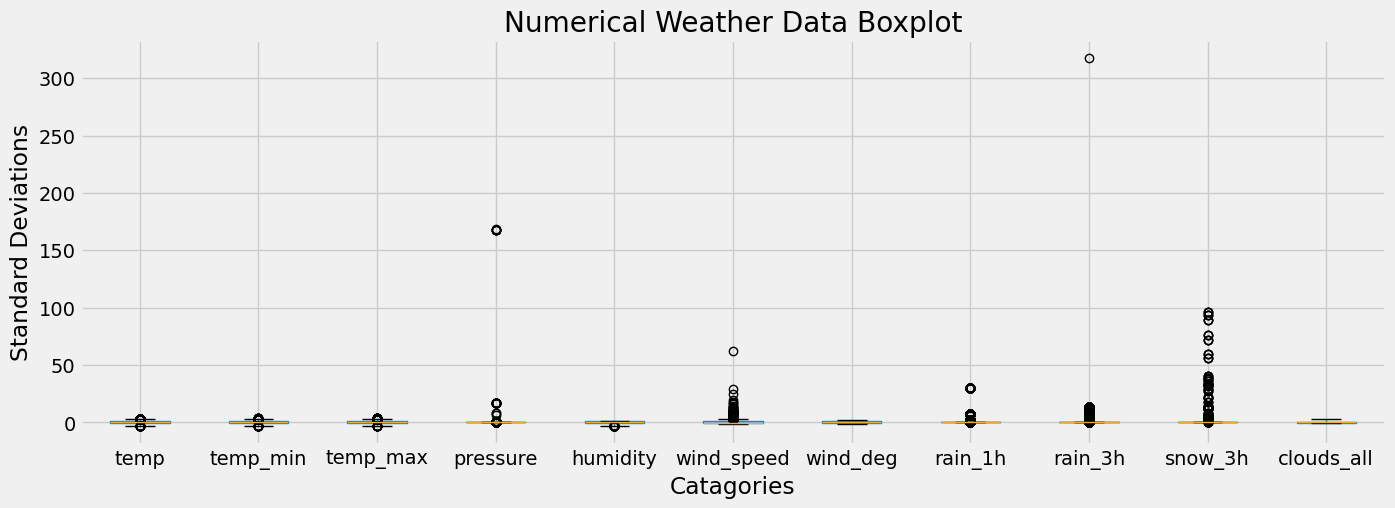

In [192]:
normalized_df = (weather_df_nums - weather_df_nums.mean()) / weather_df_nums.std()
normalized_df.boxplot(figsize = (15,5))
plt.title('Numerical Weather Data Boxplot')
plt.ylabel('Standard Deviations')
plt.xlabel('Catagories')
plt.show()

<Axes: xlabel='pressure'>

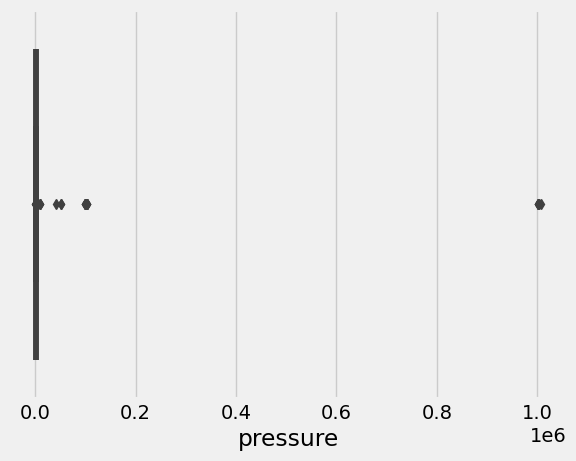

In [193]:
sns.boxplot(x = weather_df['pressure'])

In [197]:
weather_df.loc[weather_df.pressure >= 1050, 'pressure'] = np.nan
weather_df.loc[weather_df.pressure <= 950, 'pressure'] = np.nan

<Axes: xlabel='pressure'>

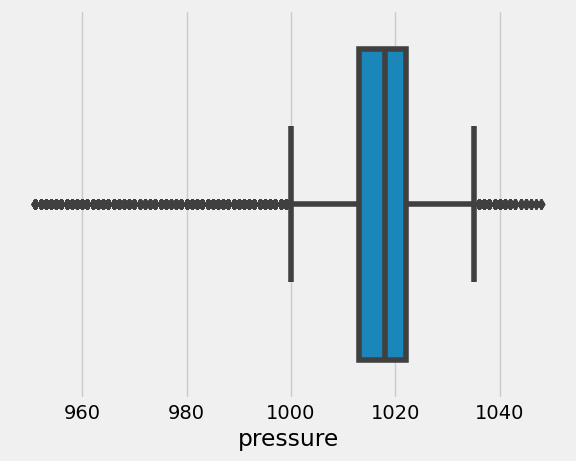

In [198]:
sns.boxplot(x = weather_df['pressure'])

<Axes: xlabel='wind_speed'>

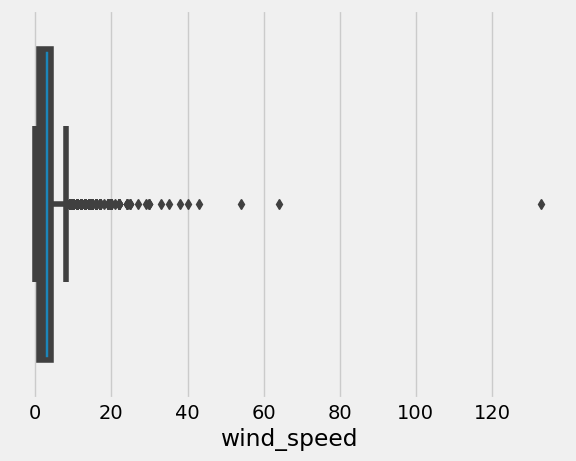

In [199]:
sns.boxplot(x = weather_df['wind_speed'])

<Axes: xlabel='wind_speed'>

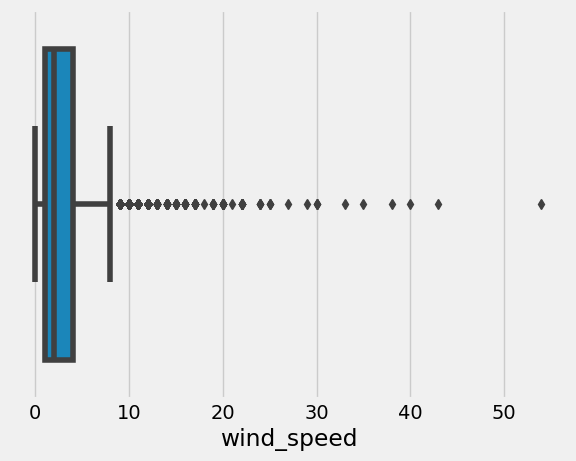

In [204]:
weather_df.loc[weather_df['wind_speed'] >= 60, 'wind_speed'] = np.nan
sns.boxplot(x=weather_df.wind_speed)

In [44]:
def percentage_error(df, actual, target, new_column_name):
    actual, target = np.array(df[actual]), np.array(df[target])
    df[new_column_name] = np.abs((actual - target) / actual) * 100
    return df